# What should speakers talk about in order to be quoted?

## Part 1. Overview of most used words (introductory)
We will make use of __tokenization__ and __lemmatization__ in order to vizualize in a nice and fun way what are the most used words in the quotations.  
The goal is to gain some insight about the topics tackled in the dataset, in order to properly answer the question "WHAT?"
 
Special librairies/packages: 
* spaCy: library for nlp
* re (for regexp)
* wordcloud

The tokenizer code can be found in [tokenizer.py](tokenizer.py) and is based on Spacy's `en_core_web_sm` pipeline. What is done in this part is simply filtering some irrelevant stop words (such as "the", "it", etc.) and lemmatizing (reduce word form to their canonical form, within context) the others in order to obtain an insightful corpus.  
Since tokenization is a computationally expensive task, and this part is only for introductory purposes, we will only consider a random sample of size 10'000 from the clean-2020 dataset.

In [1]:
import spacy
from tokenizer import tokenizer
import pandas as pd
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [4]:
df = pd.read_csv('clean-quotes-2020.bz2', compression='bz2', nrows=100000)
n = 10000
df_sample = df.sample(n=n, random_state=1)

df_sample['quotation-token'] = df_sample['quotation'].map(lambda x: tokenizer(x, nlp, stop_words))
text = ' '.join(df_sample['quotation-token'])

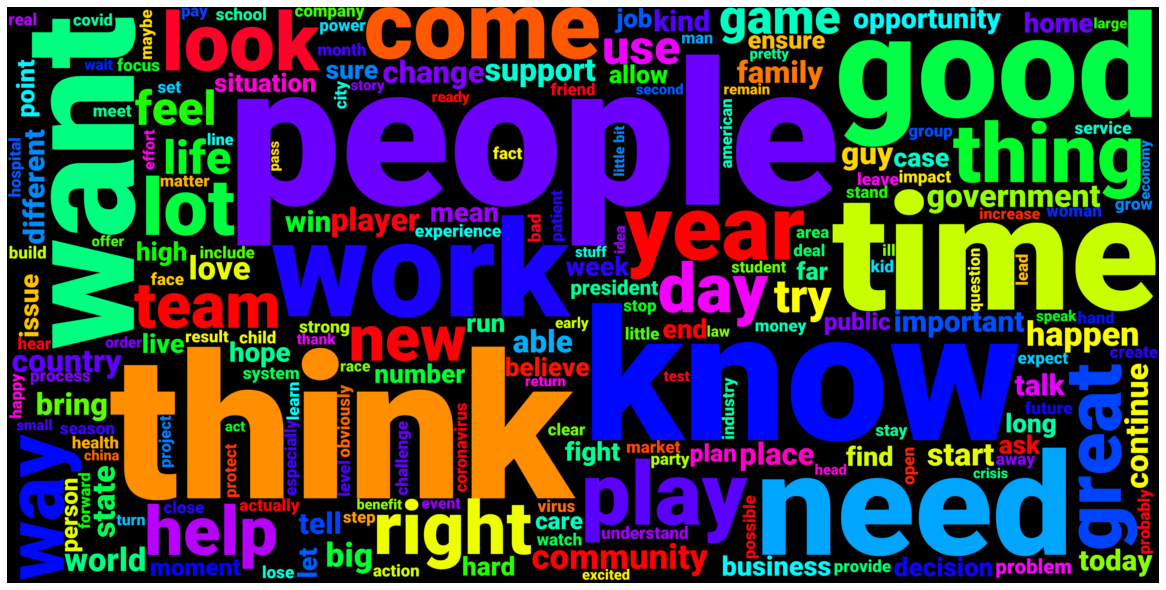

In [5]:
font_path = "Roboto/Roboto-Black.ttf"
# lower max_font_size
wordcloud = WordCloud(font_path=font_path,width=6000, height=3000,background_color="black",colormap='Set1').generate(text)
wordcloud.recolor(colormap='gist_rainbow', random_state=1)
#black: gist_rainbow
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#wordcloud.to_file("wordcloud-10k-black.png")

From this vizualization, we observe a dominance of verb entities ("want", "think", "look", "come", "need", etc.) that are an important ingredient of human speech. More interestingly, one can identify lots of words associated with politics, business, population, coronavirus, etc..

## Part 2. Zero-shot text classification
In the framework of our project, one wants to be able to classify quotes into various topics, so that we can answer the question "what is the quotation about?".

As we do not want to handcraft labels on our data, we prefer using existing classifiers that are pre-trained on large datasets. This is called zero-shot text classification.  
Note: the approach is highly inspired by these very good medium posts: 
* [Zero-Shot Text Classification Made Easy](https://medium.com/vennify-ai/zero-shot-text-classification-made-easy-d6ddc6b8efbd)
* [Zero-Shot Text Classification with Hugging Face](https://towardsdatascience.com/zero-shot-text-classification-with-hugging-face-7f533ba83cd6)

We will be using the following fine-tuned model, appropriate for the task of zero-shot text classification: DistilBERT base model uncased ([see there](https://huggingface.co/typeform/distilbert-base-uncased-mnli)). This model is fine-tuned on Multi-Genre Natural Language Inference (MNLI) dataset for the zero-shot classification task. The model is not case-sensitive, i.e., it does not make a difference between "english" and "English".

In [ ]:
%%capture
from transformers import pipeline
import pandas as pd
import re
import numpy as np
from timeit import default_timer as timer

task = "zero-shot-classification"
# see there: https://huggingface.co/typeform/distilbert-base-uncased-mnli
model = "typeform/distilbert-base-uncased-mnli"
classifier = pipeline(task, model, device=0)

The classifier is easy to implement and we only have to define the set of possible labels. For each quotation, the language model will extract the semantic meaning of it and will assess similarity with each of the proposed topics. For this purpose, we chose to store the top 3 confidence output of the model, as there may be multiple topics tackled in a given quote. For example, for a quote about coronavirus vaccine coverage in the U.S., we would expect the model to detect ['politics', 'U.S.', 'science'] as potential labels.

For Milestone 2, we decided to test it on a random sample of 100'000 quotations from 2020 data. The goals are the following:
- Show that our approach is scalable and we can handle the data in its size for this task
- Visually validate some of the model's outputs, to assess the performance of this approach

The set of quotation topics considered is inspired by the previous visualization, and standard subjects from The New York Times: 
<p align="center">
  <img src="nytimes-subjects.png" alt="ny" width="500">
</p>
<br>
Here, we apply our text classification model with the following class labels:

- politics
- world
- U.S.
- economy
- business
- culture
- sport
- science
- technology

In [ ]:
labels = ["politics", "world", "U.S.", "economy", "culture", "sport", "business", "science", "technology"]

n=100000
m=len(labels)
df = pd.read_csv('/home/zemour/clean-quotes-2020.bz2', compression='bz2')
df2 = df.sample(n=n, random_state=1)

start = timer()
df2['topic'] = df2['quotation'].map(lambda x: classifier(x, labels)['labels'][0:3]) # where everything happens..
end = timer()
print('Done classifying {:d} quotes with {:d} labels after {:.3f} seconds.'.format(n, m, end - start))

df2.to_csv('/home/zemour/labelled-quotes-2020.bz2', compression='bz2')


/home/zemour/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:908: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Done classifying 100000 quotes with 9 labels after 651.850 seconds.


As shown by the previous cell, the model managed to classify 100'000 quotes in about 10 minutes (on GPU). Note that the more candidate labels we have, the longer the running time will be, so it is important to select few insightful topics for this classification task.

For the rest of the project, we aim to fine tune the candidate labels using the information gathered around the speakers. Indeed, one would expect a politician to talk about politics, and a sportsman (though not always) to talk about sports. By doing so, we would be able to extract a precise topic from a given quotation, without having to consider a too large set of candidate labels.  
_As a concrete example, lets say we are answering the "what?" for politicians quotations. We could consider the following topics: immigration, gun control, healthcare, elections, security, etc._ 

In [10]:
df_labels = pd.read_csv('labelled-quotes-2020.bz2', compression='bz2')

In [15]:
import ast
from collections import Counter

topics = list(df_labels.topic)
t =  Counter([ast.literal_eval(x)[0] for x in topics])
t = {k:v/1000 for k,v in dict(t).items()}

tab = {"Top 1 label (%)": t}
print(pd.DataFrame.from_dict(tab))

            Top 1 label (%)
U.S.                 10.838
business              9.083
culture              11.645
economy               8.845
politics             22.235
science               0.592
sport                12.400
technology            2.658
world                21.704
